In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
import geopandas as gpd
import shapely

flopy is installed in /Users/mnfienen/Documents/GIT/flopy/flopy


### Loading and modifying a MODFLOW 6 model

A existing MODFLOW 6 model will be loaded and modified to include a river discretized using a shapefile..

The model we are using is the model developed by Freyberg () The model domain is into 1 layer, 40 rows, and 20 columns. 

Before loading the simulation object you should define the simulation workspace (`sim_ws`) where the model files are, the simulation name (`name`), and the name and path of the model executable (`exe_name`).  The `sim_ws` should be set to `'data/ex01b'`, `name` should be set to `ex01b`

## N.B. --> `exe_name` should be set to wherever you have located `mf6`.

In [2]:
ws = 'work/ex03'
name = 'ex03'
exe_name = os.path.abspath('../../working/bin/mf6')

Load a simulation object using `flopy.mf6.MFSimulation().load()`.

In [3]:
sim = flopy.mf6.MFSimulation().load(sim_name=name, exe_name=exe_name,
                                    sim_ws='data/freyberg_mf6/')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package wel...
    loading package riv...
    loading package rch...
    loading package chd...
  loading ims package freyberg6...


Change the workspace

In [4]:
sim.set_sim_path(ws)

Retrieve the gwf model object using `sim.get_model()`. First use `sim.model_names` to get the name of the groundwater model.

In [5]:
sim.model_names

odict_keys(['freyberg6'])

In [6]:
gwf = sim.get_model('freyberg6')

#### Create the river package

Load the river shapefile using geopandas. 

In [7]:
spth = 'data/freyberg/GIS/Flowline_river.shp'
rshp = gpd.read_file(spth)

Plot the shapefile on the model grid.

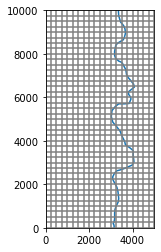

In [8]:
ax = rshp.plot()
gwf.modelgrid.plot(ax=ax)

Determine what is in the geometry

In [9]:
rshp.geometry

0    LINESTRING (3346.498 10010.586, 3363.599 9754....
Name: geometry, dtype: geometry

Create a intersection object from the modelgrid

In [10]:
ixobj = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid, method='structured')

Intersect the geometry object and the river shapefile goemetry

In [11]:
rint = ixobj.intersect_linestring(rshp.geometry[0])

Plot the intersected river and the model grid

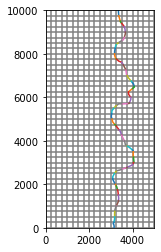

In [12]:
ax = ixobj.plot_linestring(rint)
gwf.modelgrid.plot(ax=ax)

What is in the intersected river object? It is a recarray so lets output the dtype.names.

In [13]:
rint.dtype.names

('cellids', 'vertices', 'lengths', 'ixshapes')

The zero-based row and column locations are in the `'cellids'` column. 

In [14]:
rint['cellids']

array([(0, 13), (1, 13), (2, 13), (2, 14), (3, 14), (4, 14), (5, 14),
       (5, 13), (6, 13), (6, 12), (7, 12), (8, 12), (8, 13), (9, 13),
       (9, 14), (10, 14), (11, 14), (11, 15), (12, 15), (13, 15),
       (13, 16), (14, 15), (14, 16), (15, 15), (16, 15), (17, 15),
       (17, 14), (17, 13), (17, 12), (18, 12), (19, 12), (20, 12),
       (21, 12), (21, 13), (22, 13), (22, 14), (23, 14), (24, 14),
       (24, 15), (25, 15), (25, 16), (26, 16), (27, 16), (28, 16),
       (28, 15), (28, 14), (29, 14), (29, 13), (29, 12), (30, 12),
       (31, 12), (32, 12), (32, 13), (33, 13), (34, 13), (35, 13),
       (36, 13), (36, 12), (37, 12), (38, 12), (39, 12)], dtype=object)

The lengths of each river component are in the `'lengths'` column. Set a `rlen` variable to `rint['lengths']`.

In [15]:
rlen = rint['lengths'].copy()
rlen

array([250.71835918, 260.58889922, 116.40303199, 191.92306733,
       258.06622205, 256.92339594, 199.44412135, 194.41142808,
       119.82389196, 177.04412864, 252.39824312, 252.68238853,
        26.04670151, 278.74627965, 122.65759838, 279.9979019 ,
       256.34963068,   3.44678172, 310.60844164, 106.24076249,
       187.05877656, 240.99077815, 135.02503893, 281.20477884,
       265.97033132, 127.10529604, 250.3837113 , 280.31530203,
       156.2831783 , 282.2717055 , 255.19712296, 290.24399569,
        96.2627672 , 222.92345277, 269.83231615,   9.51011227,
       277.80012767, 282.37514077,  27.45720497, 288.56417636,
        86.99414373, 250.56126814, 256.13945734,  95.1125441 ,
       292.1361721 ,  83.49689616, 184.35873236, 270.45071336,
       128.13631163, 267.78199342, 278.33994138,  88.81729799,
       182.90081567, 253.6237694 , 251.53847606, 271.36253678,
         3.53037069, 257.97097199, 250.38178407, 253.65510135,
       270.70447278])

The river is located in layer 1 and the zero-based row, column locations in `rint['cellids']`. The river stage stage and bottom are at 20.1 and 20.0 in row 1, respectively. The river stage stage and bottom are at 11.25 and 10.25 in row 40, respectively. The river conductance is 0.5e-1.

We are going to linearly interpolate the river stage and bottom from the values in row 1 and row 40. For that we will need the total length of the river.

In [16]:
rlentot = rint['lengths'].sum()
rlentot

12419.290359618693

The slope of the river stage and river bottom are $\frac{11.25 - 20.1}{rlentot}$ and $\frac{10.25 - 20.0}{rlentot}$, respectively. 

In [17]:
rstage_us, rbot_us = 20.1, 20.0
rstage_ds, rbot_ds = 11.25, 10.25

In [18]:
dstage, drbot = (rstage_ds - rstage_us) / rlentot, (rbot_ds - rbot_us) / rlentot
dstage, drbot

(-0.0007126011022961316, -0.0007850690110042126)

Create numpy arrays for the interpolated river stage and river bottom that will be used to create the river package.

In [19]:
rstage = np.zeros(rint.shape[0], dtype=np.float)
rbot = np.zeros(rint.shape[0], dtype=np.float)

Calculate interpolated river stage and river bottom.

In [20]:
rlencum = 0.
for idx in range(rstage.shape[0]):
    if idx == 0:
        rlencum = 0.5 * rlen[idx]
    else:
        rlencum += 0.5 * (rlen[idx-1] + rlen[idx])
    rstage[idx] = rstage_us + rlencum * dstage
    rbot[idx] = rbot_us + rlencum * drbot

In [21]:
rstage

array([20.01066891, 19.82848985, 19.69416742, 19.58431066, 19.42397923,
       19.24048814, 19.07788415, 18.9375532 , 18.82559098, 18.71981674,
       18.56680619, 18.38684568, 18.28753435, 18.17893644, 18.03591602,
       17.89244964, 17.70134872, 17.60878312, 17.49688507, 17.34836147,
       17.24385868, 17.09134439, 16.95736974, 16.80906683, 16.61410804,
       16.47405497, 16.33955543, 16.15046708, 15.9949068 , 15.83864946,
       15.64714902, 15.45280805, 15.31509547, 15.20136925, 15.02580009,
       14.92627023, 14.82390144, 14.62431068, 14.51391724, 14.40131865,
       14.26750702, 14.14723584, 13.96669809, 13.84154681, 13.70356988,
       13.56973161, 13.4742945 , 13.31224564, 13.17022887, 13.02916295,
       12.83457941, 12.70376108, 12.60694777, 12.45141382, 12.27142423,
       12.08511431, 11.98716982, 11.89399675, 11.71287038, 11.53328176,
       11.34645215])

In [22]:
rbot

array([19.90158439, 19.70087865, 19.55289631, 19.43186768, 19.25523135,
       19.05308016, 18.87394016, 18.71933827, 18.59599006, 18.47945912,
       18.31088817, 18.11262659, 18.00321581, 17.88357405, 17.72600917,
       17.567953  , 17.35741808, 17.25543903, 17.13216152, 16.96853382,
       16.85340363, 16.68537941, 16.53778023, 16.37439566, 16.15961055,
       16.0053148 , 15.85713734, 15.64881967, 15.4774397 , 15.30529177,
       15.09431671, 14.88021225, 14.72849501, 14.60320341, 14.40977976,
       14.30012822, 14.18734904, 13.96746092, 13.84584103, 13.72179173,
       13.57437214, 13.44186999, 13.24297247, 13.10509394, 12.95308546,
       12.80563652, 12.70049394, 12.52196554, 12.36550638, 12.21009478,
       11.99572308, 11.85160119, 11.74494246, 11.57359149, 11.37529788,
       11.17004119, 11.06213624, 10.95948794, 10.75994194, 10.56209007,
       10.35626085])

Remove the existing river package. Use `gwf.package_names` to determine the name of the river package.

In [23]:
gwf.package_names

['dis', 'ic', 'npf', 'oc', 'basewell', 'riv_0', 'rch_0', 'chd_0']

Remove the existing river package using `gwf.remove_package()`.

In [24]:
gwf.remove_package('riv_0')

Create a list of lists with the river package data. The river package data has the form:

    [[(k, i, j), rstage, conductance, rbot, iface],
                       .
                       .
                       .
     [(k, i, j), rstage, conductance, rbot, iface]]

`iface` is an auxillary variable that is used by MODPATH. We will assume that the river is on the top of the model cell (`IFACE` = 6).

In [25]:
riv_spd = []
for idx in range(rint.shape[0]):
    i, j = rint['cellids'][idx]
    riv_spd.append([(0, i, j), rstage[idx], 0.5e-1, rbot[idx], 6.])

In [26]:
riv_spd[:3]

[[(0, 0, 13), 20.010668910442433, 0.05, 19.901584392860308, 6.0],
 [(0, 1, 13), 19.828489852471233, 0.05, 19.70087865102763, 6.0],
 [(0, 2, 13), 19.69416741960274, 0.05, 19.55289630973183, 6.0]]

Create the new river package

In [27]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, auxiliary=['iface'])

#### Write the model files and run the model

In [28]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package freyberg6...
  writing model freyberg6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package basewell...
    writing package rch_0...
    writing package chd_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 61 based on size of stress_period_data
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/mf6flopy2019_Neuchatel/working/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been

(True, [])

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `flopy.utils.HeadFile()` method. The cell-by-cell file can be loaded with the `flopy.utils.CellBudgetFile()` method. MODFLOW 6 creates double precision binary files so `precision='double'` needs to be passed to the `flopy.utils.CellBudgetFile()` method. The `flopy.utils.HeadFile()` method autodetects the precision of the head file. The precision of the head file is a attribute on the head file object (`hobs.precision`) and could be passed as the `precision` parameter.

In [29]:
hname = gwf.oc.head_filerecord.array[0][0]
cname = gwf.oc.budget_filerecord.array[0][0]
hname, cname

('freyberg6.hds', 'freyberg6.cbb')

In [30]:
fpth = os.path.join(ws, hname)
hobj = flopy.utils.HeadFile(fpth)

In [31]:
hds = hobj.get_data()

In [32]:
fpth = os.path.join(ws, cname)
cobj = flopy.utils.CellBudgetFile(fpth, precision=hobj.precision)

The entries in the cell-by-cell file can be determined with the `.list_unique_records()` method on the cell budget file object.

In [33]:
cobj.list_unique_records()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
WEL                  6
RIV                  6
RCH                  6
CHD                  6


Retrieve the `'DATA-SPDIS'` data type from the cell-by-cell file.

In [34]:
spd = cobj.get_data(text='DATA-SPDIS')[0]

#### Plot the results

Plot the results using `flopy.plot.PlotMapView()`. The head results can be plotted using the `.plot_array()` method. The discharge results can be plotted using the `plot_specific_discharge()` method. Boundary conditions can be plotted using the `.plot_bc()` method.

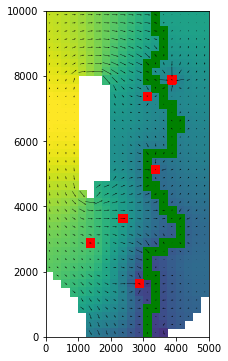

In [35]:
mm = flopy.plot.PlotMapView(model=gwf, layer=0)
mm.plot_array(hds, masked_values=[1e30])

fig = plt.gcf()
fig.set_size_inches(3, 6)

mm.plot_bc('RIV')
mm.plot_bc('WEL')
mm.plot_specific_discharge(spd)
